In [3]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
import re #regex
import os
from datetime import date, datetime, timedelta
import math
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt
import seaborn as sns
# Set style & figures inline
sns.set()
%matplotlib inline

## Web Scrapping Functions

In [4]:
# Extracts data from the webpage using lxml.html
def extract_table(url,xpath_all,contains_header):
    
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url)
    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)

    col_all=[]
    nrows=[] # number of rows for each table
    
    for xpath in xpath_all:
        print("Path used in collecting data: {}".format(xpath))
        #Parse data that are stored between <tr>..</tr> of HTML
        tr_elements = doc.xpath(xpath)
        
        #Check the number of columns of the first 12 rows
        print("Number of columns of the table:")
        print([len(T) for T in tr_elements[:18]])

        #Create empty list
        #tables that store a header (if there's one) and data
        #assuming all tables have the same header
        col=[]  

        ## Getting header
        i=0
        #For each row, store each first element (header)
        #and an empty list
        print("Table Header:")
        for t in tr_elements[0]:
            if contains_header==True:
                name=t.text_content()
            else:
                name=contains_header[i]
            i+=1
            print('%d:"%s"'%(i,name))
            col.append((name,[]))
            
        ## Getting data
        if contains_header==True:
            start_ind = 1
        else:
            start_ind = 0

        #nrows_current = 0
        for j in range(start_ind,len(tr_elements)):

            # break if reaching end of table
            #if len(tr_elements[j]) != len(tr_elements[0]):
            if j > 14:
                break
            i = 0    
            for ele in tr_elements[j].iterchildren():
                data = ele.text_content().strip()

                #check data
                p1 = re.search("^[A-Za-z]+", data)
                p2 = re.search('^[0-9,]+[\\n]*', data)

                if p1:
                    col[i][1].append(data)
                elif p2:
                    value = data[:p2.span()[1]].replace(",","")
                    if (re.search("\\n", value)):
                        value = value[:-1]
                    col[i][1].append(int(value))

                #Increment i for the next column
                i+=1
            
        col_all.append(col)
    return col_all

# Stores extracted data into dataframe(s)
def create_dataframe(table,num_table):

    df_all = pd.DataFrame()

    for t in range(0,num_table):
        Dict={title:column for (title,column) in table[t]}
        df=pd.DataFrame(Dict)
        df['Date'] = date.today()
        df_all=df_all.append(df,ignore_index=True)

    return df_all

## Extract data from the web

In [3]:
# Obtained data from the following website
url='https://www.covid-19canada.com'
#xpath1_1='//tr'
xpath1_1='//table[@id="canada-board"]//tr'
header = ["Province", "Total Confirmed", "Total Deaths", "Total Recovered", "Total Active"]
data = extract_table(url,[xpath1_1], contains_header=header)

print(data)

Path used in collecting data: //table[@id="canada-board"]//tr
Number of columns of the table:
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Table Header:
1:"Province"
2:"Total Confirmed"
3:"Total Deaths"
4:"Total Recovered"
5:"Total Active"
[[('Province', ['Prov.', 'Total', 'BC', 'ON', 'QC', 'AB', 'MB', 'NB', 'SK', 'PEI', 'NL', 'NS', 'YT', 'NT', 'NU']), ('Total Confirmed', ['Total Confirmed', 1403008, 146176, 540130, 373112, 230578, 54481, 2299, 47996, 206, 1379, 5749, 104, 128, 657]), ('Total Deaths', ['Total Deaths', 25940, 1730, 8961, 11173, 2270, 1102, 45, 556, 0, 7, 90, 2, 0, 4]), ('Total Recovered', ['Total Recovered', 1360766, 142526, 525795, 360194, 225219, 50268, 2163, 46666, 202, 1329, 5535, 84, 128, 644]), ('Total Active', ['Total Active', 16263, 1885, 5374, 1745, 3089, 3111, 91, 774, 4, 39, 124, 18, 0, 9])]]


In [4]:
df_1 = create_dataframe(data,len([xpath1_1]))

#remvoe the first row (header)
df_1.drop(labels = [0], axis = 0, inplace = True)
df_1.reset_index(drop = True, inplace = True)
print(df_1)

   Province Total Confirmed Total Deaths Total Recovered Total Active  \
0     Total         1403008        25940         1360766        16263   
1        BC          146176         1730          142526         1885   
2        ON          540130         8961          525795         5374   
3        QC          373112        11173          360194         1745   
4        AB          230578         2270          225219         3089   
5        MB           54481         1102           50268         3111   
6        NB            2299           45            2163           91   
7        SK           47996          556           46666          774   
8       PEI             206            0             202            4   
9        NL            1379            7            1329           39   
10       NS            5749           90            5535          124   
11       YT             104            2              84           18   
12       NT             128            0           

## Combine new daily extracted data to previous data

In [5]:
### Export the current df to existing file (previous data)
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data")
os.makedirs(save_path, exist_ok = True)

num_dataset = len(df_1.index)


for i in range(num_dataset):
    temp_df = df_1.loc[df_1[df_1.columns[0]] == df_1.loc[i][df_1.columns[0]]]

    #load current df and then perform merge before saving
    file_fullpath = os.path.join(save_path,df_1.loc[i][df_1.columns[0]] + ".csv")
    if os.path.exists(file_fullpath):
        orig_dataset = pd.read_csv(file_fullpath)    
        
        #reindex new df to match with existing data
        temp_df.reindex(columns=orig_dataset.columns)
        
        new_dataset = pd.merge(orig_dataset, temp_df, how = 'outer', 
                               on = list(orig_dataset.columns))
        new_dataset.drop_duplicates(subset=['Total Confirmed','Date'], 
                                    keep = 'first', inplace = True)
        #print(new_dataset)
        new_dataset.to_csv(file_fullpath, index = False)
    else:
        temp_df.to_csv(file_fullpath, index = False)

## Examine the data

In [5]:
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data")

# select the provinces to look at
target = ['Total', 'ON', 'QC', 'BC', 'AB']

df = []
# import updated data
for i in range(len(target)):
    file_fullpath = os.path.join(save_path, target[i] + ".csv")
    df_temp = pd.read_csv(file_fullpath)
    #df_temp.drop_duplicates(subset=['Total Confirmed','Date'], keep = 'first', inplace = True)
    df_temp.drop_duplicates(subset=['Date'], keep = 'last', inplace = True)
    #print(df_temp.tail(2))
    #continue
    df_temp = df_temp.set_index('Date')
    df.append(df_temp)
    
    #print('\n\n****** ' + df_temp['Province'][0] + ' ******')
    #print(df_temp.tail(5))
    #df_temp.iloc[:, 1:5].plot(figsize=(20,10), style='o', ms=10, fontsize=20, rot = 45)
    #plt.xlabel('Date', fontsize=20);
    #plt.ylabel('Patients count', fontsize=20);
    #plt.title('Time Series for ' + target[i], fontsize=20)
    #plt.show()

## 1st Model Fitting: Gaussian

In [6]:
# function for fitting (normal distribution function)
def func_normal(x,a,x0,sigma):
    return (a/sigma)*np.exp(-(x-x0)**2/(2*sigma**2))

# specify the formats of dates in the dataset
def try_parsing_date(text):
    for fmt in ('%Y-%m-%d', '%d-%m-%Y'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')
    
# dividing zero function
def division(r,d):
    return (r / d if d != 0 else r)

In [7]:
# computes the weekly average
def getWeeklyAverage(xdata, x_data_in_day, y_data_change_per_day, year_start):
    #year_start = 2020
    
    df = pd.DataFrame(data = {'Date': xdata, 
                              'Date_Num': x_data_in_day, 
                              'Daily_Increase': y_data_change_per_day})
    df['Date_formatted'] = pd.to_datetime(df['Date'], format="%d-%m-%Y",  errors='coerce')
    mask = df.Date_formatted.isnull()
    df.loc[mask, 'Date_formatted'] = pd.to_datetime(df[mask]['Date'], 
                                                    format="%Y-%m-%d", errors='coerce')
    #df['Week'] = df['Date_formatted'].dt.week
    df['Week'] = df['Date_formatted'].dt.isocalendar().week #get week number
    
    df.loc[(df['Date_formatted'].dt.year > year_start) & 
                   (df['Week'] < date(year_start,12,31).isocalendar()[1]), 'Week'] = \
    df['Date_formatted'].dt.isocalendar().week + date(year_start, 12, 31).isocalendar()[1]
    
    df['Week_midpoint'] = df.groupby('Week')[['Date_Num']].transform('median')
    
    #print(df.tail(10))
    #print(df.groupby('Week')['Date_formatted'].transform('min'))
    
    weekly_avg = df.groupby('Week')[['Week_midpoint','Daily_Increase']].mean()
    #print(weekly_avg)
    return weekly_avg


121


****** Total ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-06-09    Total        1396335.0       25835.0        1349816.0   
2021-06-10    Total        1397831.0       25862.0        1352213.0   
2021-06-11    Total        1399716.0       25886.0        1355419.0   
2021-06-13    Total        1402060.0       25931.0        1359109.0   
2021-06-14    Total        1403008.0       25940.0        1360766.0   

            Total Active  
Date                      
2021-06-09       20629.0  
2021-06-10       19715.0  
2021-06-11       18367.0  
2021-06-13       16976.0  
2021-06-14       16263.0  


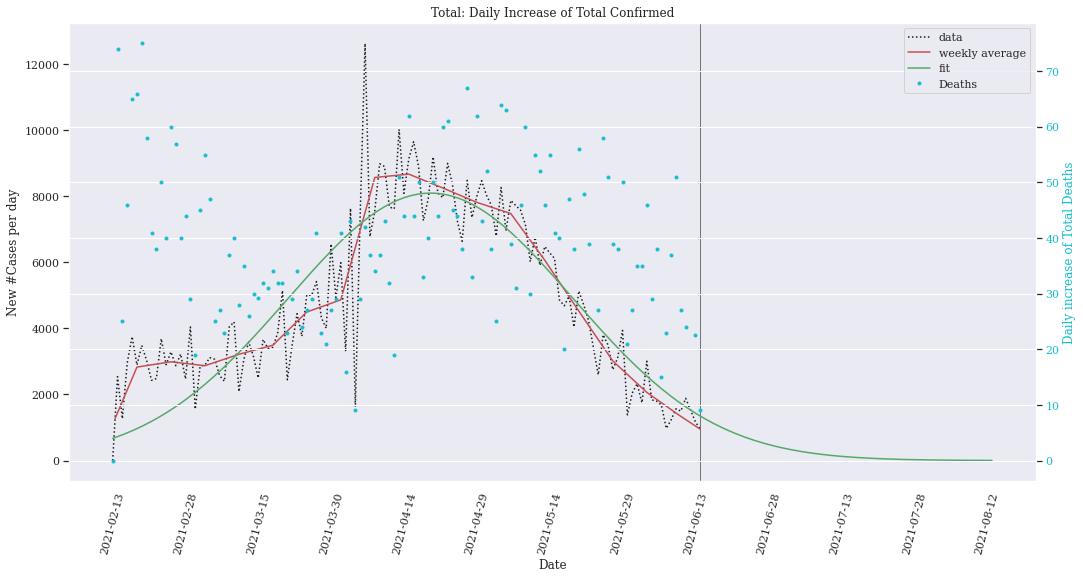

107


****** ON ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-06-09       ON         537487.0        8920.0         521743.0   
2021-06-10       ON         538077.0        8931.0         522682.0   
2021-06-11       ON         538651.0        8935.0         523532.0   
2021-06-13       ON         539683.0        8957.0         525125.0   
2021-06-14       ON         540130.0        8961.0         525795.0   

            Total Active  
Date                      
2021-06-09        6824.0  
2021-06-10        6464.0  
2021-06-11        6184.0  
2021-06-13        5601.0  
2021-06-14        5374.0  


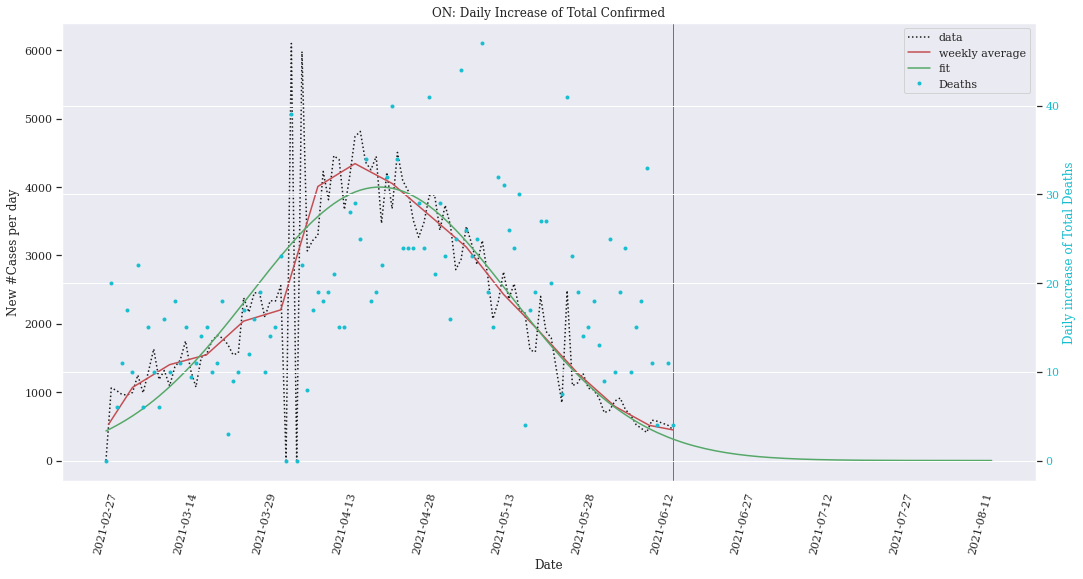

92


****** QC ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-06-09       QC         372287.0       11164.0         358849.0   
2021-06-10       QC         372476.0       11166.0         359104.0   
2021-06-11       QC         372656.0       11167.0         359421.0   
2021-06-13       QC         372989.0       11172.0         359981.0   
2021-06-14       QC         373112.0       11173.0         360194.0   

            Total Active  
Date                      
2021-06-09        2274.0  
2021-06-10        2206.0  
2021-06-11        2068.0  
2021-06-13        1836.0  
2021-06-14        1745.0  


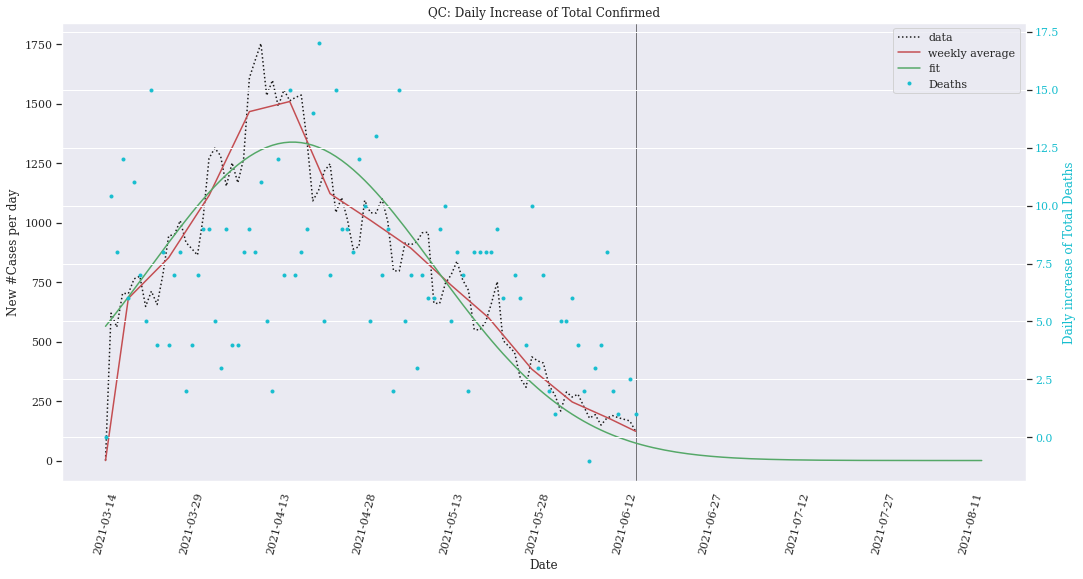

87


****** BC ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-06-09       BC         145695.0        1722.0         141879.0   
2021-06-10       BC         145843.0        1725.0         142106.0   
2021-06-11       BC         146176.0        1730.0         142526.0   
2021-06-13       BC         146176.0        1730.0         142526.0   
2021-06-14       BC         146176.0        1730.0         142526.0   

            Total Active  
Date                      
2021-06-09        2043.0  
2021-06-10        1975.0  
2021-06-11        1880.0  
2021-06-13        1880.0  
2021-06-14        1885.0  


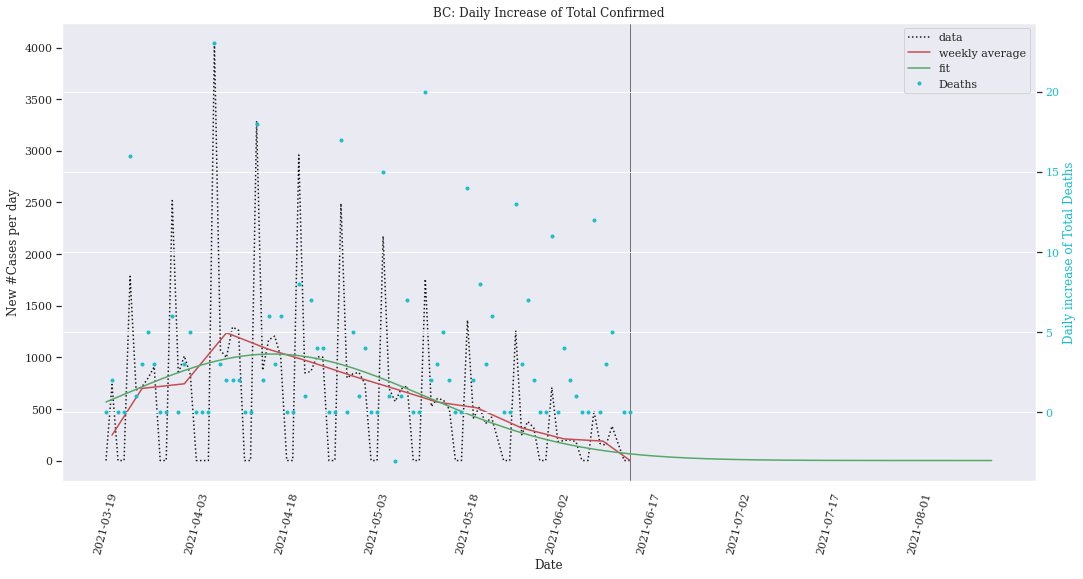

95


****** AB ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-06-09       AB         229458.0        2251.0         222776.0   
2021-06-10       AB         229771.0        2256.0         223311.0   
2021-06-11       AB         230119.0        2265.0         224325.0   
2021-06-13       AB         230463.0        2270.0         225013.0   
2021-06-14       AB         230578.0        2270.0         225219.0   

            Total Active  
Date                      
2021-06-09        4431.0  
2021-06-10        4204.0  
2021-06-11        3529.0  
2021-06-13        3180.0  
2021-06-14        3089.0  


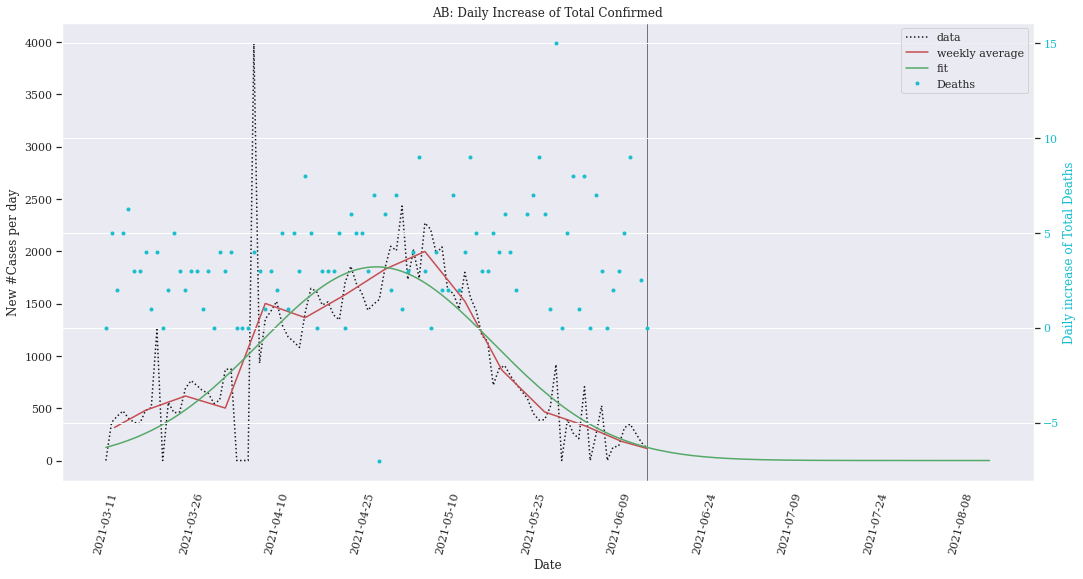

In [26]:
for cur_df in df:
    
    #define main axis parameter
    data_examined = cur_df.columns.get_loc('Total Confirmed')
    #define secondary axis parameter
    second_param = 'Total Deaths'
    
    ydata = cur_df.iloc[:, data_examined].transpose()
    xdata = cur_df.index
    
    # 2021-04-16 added #########################
    # ignore the first 340 data points to look at the 3rd wave
    start_point = 340
    xdata = xdata[start_point:]
    ydata = ydata[start_point:]
    ############################################
    # 2021-06-14 added
    from datetime import datetime
    today = datetime.today()
    days_diff = today - try_parsing_date(xdata[0])
    print(days_diff.days)
    ############################################
    
    xdata = xdata[~ydata.apply(np.isnan)]
    ydata = ydata[~ydata.apply(np.isnan)]#ydata.replace(np.nan, '', regex=False)
    
    x_data_2 = [try_parsing_date(x) for x in xdata]
    year_start = x_data_2[0].year
    
    # convert time to days since first record
    x_data_in_sec = [int(x.timestamp()) - int(x_data_2[0].timestamp()) for x in x_data_2]
    x_data_in_day  = np.array([x / 3600 / 24 for x in x_data_in_sec])
    
    # compute the increase in confirmed cases from total
    x_data_in_day_diff = np.ediff1d(x_data_in_day, to_begin=0)
    y_data_change = np.ediff1d(ydata, to_begin=0)
    y_data_change_per_day = np.array([division(y,x) for y,x in 
                                      zip(y_data_change,x_data_in_day_diff)])
    
    # compute the weekly average
    weekly_avg = getWeeklyAverage(xdata, x_data_in_day, y_data_change_per_day, year_start)
    
    # ignore datapoints where count is zero
    #nonzero_indices = np.where(y_data_change_per_day != 0.0)[0]
    #x_data_in_day = x_data_in_day[nonzero_indices]
    #y_data_change_per_day = y_data_change_per_day[nonzero_indices]

    
    print('\n\n****** ' + cur_df['Province'][0] + ' ******')
    print(cur_df.tail(5))
    
    
    # compute the curvefit
    n = len(x_data_in_day)
    mean = float(sum(y_data_change_per_day))/n
    sigma = np.sqrt(sum((y_data_change_per_day-mean)**2))/np.sqrt(n-1)
    init_vals = [10000, mean, sigma]
       
    # fit your data and getting fit parameters
    popt, pcov = curve_fit(func_normal, x_data_in_day, y_data_change_per_day, 
                           p0=init_vals, maxfev = 100000)
    
    
    # Create the figures
    x_end = math.ceil(x_data_in_day[len(x_data_in_day)-1])
    x_extend = np.array(range(x_end, x_end+61))
    
    xdisplay = [ (try_parsing_date(cur_df.index[start_point]) + 
                  timedelta(days=t)).strftime("%Y-%m-%d") for t in range(0,max(x_extend))]
        
    fig, ax = plt.subplots(figsize=(15,8))
    #plt.clf()
    
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'figure.autolayout': True, 
                         'font.size': 5})    
    
    plt.axvline(x=days_diff.days, color = 'black', linewidth=0.5)
    
    lns1 = ax.plot(x_data_in_day, y_data_change_per_day, 'k:', label='data')
    
    lns2 = ax.plot(weekly_avg['Week_midpoint'], weekly_avg['Daily_Increase'], 
             'r-', label = 'weekly average')
    
    lns3 = ax.plot(np.concatenate((x_data_in_day, x_extend)), 
             func_normal(np.concatenate((x_data_in_day, x_extend)), *popt), 
             'g-', label='fit')
    
    plt.xticks(np.arange(x_data_in_day[0], max(x_data_in_day) + max(x_extend), step = 15), 
           labels = xdisplay[::15], rotation=75)
    
    ##secondary axis
    # fit your data and getting fit parameters
    ydata_2ndry = cur_df[second_param].fillna(value = 0, inplace = False)[start_point:]
    ydata_2ndry_change = np.ediff1d(ydata_2ndry, to_begin=0)
    ydata_2ndry_change_per_day = np.array([division(float(y),float(x)) for y,x in 
                                      zip(ydata_2ndry_change,x_data_in_day_diff)])
    #popt2, pcov2 = curve_fit(func_normal, x_data_in_day, ydata_2ndry, 
    #                       p0=init_vals, maxfev = 100000)
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:cyan'
    ax2.set_ylabel('Daily increase of ' + second_param, color=color)
    lns4 = ax2.plot(x_data_in_day, ydata_2ndry_change_per_day, 'c.', 
                    color=color, label= 'Deaths')
    #ax2.plot(np.concatenate((x_data_in_day, x_extend)), 
    #         func_normal(np.concatenate((x_data_in_day, x_extend)), *popt2), 
    #         'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    ax.grid()
    ax.set_xlabel('Date')
    ax.set_ylabel('New #Cases per day')
    ax.set_title(cur_df['Province'][0] + ': Daily Increase of ' + cur_df.columns[data_examined])
    plt.show()
    
    from sklearn.metrics import mean_squared_error
    # Calculation of Mean Squared Error (MSE) 
    y_pred = np.array(func_normal(x_data_in_day, *popt))
    #print("MSE: {}".format(mean_squared_error(y_data_change_per_day, y_pred)))


## 2nd model: Linear Regression on Cum. Cases in Logarithmic scale

In [10]:
#for cur_df in df[0:1][:]:
cur_df = df[0][:]            #only look at all the cases in Canada

#get today's date and time
today = (datetime.today() - try_parsing_date(cur_df.index[0])).days

#format x and y data for plot
xdata = cur_df.index
x_data_2 = [try_parsing_date(x) for x in xdata]
ydata = cur_df.iloc[:, 1]#.transpose()

#remove NaN elements
temp_ind = np.argwhere(~np.isnan(ydata.to_list()))
ydata = [ydata.to_list()[int(x)] for x in temp_ind]
x_data_2 = [x_data_2[int(x)] for x in temp_ind]

x_data_in_sec = [int(x.timestamp()) - int(x_data_2[0].timestamp()) for x in x_data_2]
x_data_in_day  = [x / 3600 / 24 for x in x_data_in_sec]

# ignore the first 390 data points to look at the 2nd wave
start_point = 390
x_data_in_day = x_data_in_day[start_point:]
ydata = ydata[start_point:]

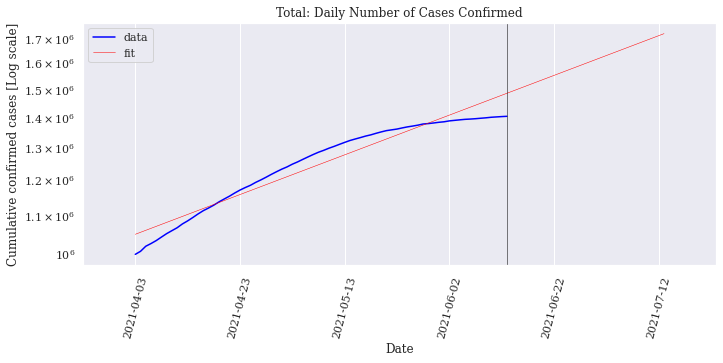

In [11]:
# curve fit, in log scale for y
#1.
#m = False
#2.
m, c = np.polyfit(x_data_in_day, np.log(ydata), 1) # fit log(y) = m*log(x) + c

#Plot: log scale in y-axis
fig,ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_yscale('log', basey=10)

x_end = math.ceil(x_data_in_day[len(x_data_in_day)-1])
x_extend = np.array(range(x_end, x_end+31))

# calculate the fitted values of y
if (m != False):
    y_fit = np.exp([m*x + c for x in np.concatenate((x_data_in_day, x_extend))])

xdisplay = [ (try_parsing_date(cur_df.index[0])
              + timedelta(days=t)).strftime("%Y-%m-%d") 
            for t in range(int(x_data_in_day[0]), max(x_extend))]

plt.rcParams.update({'font.size': 42})
plt.rcParams.update({'figure.autolayout': True, 
                     'font.size': 5, 
                     'font.family': 'serif', 
                     'font.sans-serif': ['Helvetica']})    


plt.plot(x_data_in_day, ydata, color = 'blue', label='data')
if (m != False):
    plt.plot(np.concatenate((x_data_in_day, x_extend)), 
            y_fit, color = 'red', linewidth=0.5, label='fit')
plt.axvline(x=today, color = 'black', linewidth=0.5)

plt.xticks(np.arange(min(x_data_in_day), max(x_data_in_day) + max(x_extend), step = 20), 
           labels = xdisplay[::20], rotation=75)
plt.yticks(np.arange(10^6, 2*10^6, step = 5*10^5), 
           labels = np.arange(10^6, 2*10^6, step = 5*10^5))

plt.xlim(min(x_data_in_day)-10, max(x_extend)+10)
#if (m != False):
#    plt.ylim(min(ydata)/1.5, max(y_fit)*1.5)

plt.xlabel('Date')
plt.ylabel('Cumulative confirmed cases [Log scale]')
plt.title(cur_df['Province'][0] + ': Daily Number of Cases Confirmed')
plt.legend()
plt.show()

# Covid19 Vaccine Distribution

In [12]:
import os
import pandas as pd
import selenium
from selenium import webdriver
import time
from PIL import Image
import io
import requests
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
#from selenium.common.exceptions import ElementClickInterceptedException
#import chromedriver_binary

In [101]:
# Extracts data from the webpage using selenium
def extract_table2(url, xpath_header, xpath_content):
    # Install Driver
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)

    try:
        element = WebDriverWait(driver, 60).until(
            EC.presence_of_element_located((By.XPATH, xpath_content))
        )
        #extracting data
        header = driver.find_elements_by_xpath(xpath_header)  #NOT driver.find_element_by_xpath()
        table = driver.find_elements_by_xpath(xpath_content)  #NOT driver.find_element_by_xpath()
    except:
        print("Issue with extracting info from the Chrome Browser. Please check")
        os. _exit()

    trow = []
    for num_row in range(len(table)):
        trow.append(table[num_row].text)
    theader = []
    for each_header in range(len(header)):
        # Updated in June 2021 (remove "\n"):
        theader.append(header[each_header].text.replace("\n", " "))
        

    # Prior June 2021
    #data = [[x.split('\n')[0]] + x.split('\n')[1].split(' ', 6) for x in trow]
    #print(data)
    
    # June 2021:
    data = [[re.split("\s\d",x)[0]] + re.split("(\d.+)", x)[1].split(' ',6) for x in trow]    
    
    # print info
    #print(trow)
    #print(theader)
    #print(data)
    
    # Create dataframe
    df = pd.DataFrame(data, columns = theader)
    #df
    # close chrome
    driver.quit()

    return df

In [108]:
### Export the current df to existing file (previous data)
def save_dataset(save_path, df_1):
    os.makedirs(save_path, exist_ok = True)
    num_dataset = len(df_1.index)

    for i in range(num_dataset):
        temp_df = df_1.loc[df_1[df_1.columns[0]] == df_1.loc[i][df_1.columns[0]]]

        ## load current df and then perform merge before saving
        file_fullpath = os.path.join(save_path,df_1.loc[i][df_1.columns[0]] + ".csv")
        if os.path.exists(file_fullpath):
            orig_dataset = pd.read_csv(file_fullpath, dtype = object)

            
            #PRIOR June 2021
            
            ## run if need to update the header
            #tmpHeader = list(temp_df.columns)
            #target = tmpHeader.pop(2)
            #new_tmp = tmpHeader + [target]
            #orig_dataset.columns = new_tmp #temp_df.columns
            
            ## reindex new df to match with existing data
            #temp_df.reindex(columns=orig_dataset.columns)
            
            ## '% Age population' column: 'Age' may change -->
            #fix_columns_headers = (orig_dataset.columns[:-2]).append(pd.Index([orig_dataset.columns[-1]]))
            

            # June 2021:
            if set(temp_df.columns).issubset(set(orig_dataset.columns)):
                print("NO new columns introduced...continue")
                fix_columns_headers = temp_df.columns
            else:
                print("New columns introduced in new data. Please check first")
                print(orig_dataset.columns)
                #print(dict(orig_dataset.dtypes))
                print(temp_df.columns)
                #print(dict(temp_df.dtypes))
                break
            
            #Merge datasets
            new_dataset = pd.merge(orig_dataset, temp_df, how = 'outer', 
                                   on = list(fix_columns_headers))

            
            new_dataset.drop_duplicates(subset=['Province/Territory', 'Updated'], #list(new_dataset.columns), 
                                        keep = 'last', inplace = True)
            #print(new_dataset)
            new_dataset.to_csv(file_fullpath, index = False)
        else:
            temp_df.to_csv(file_fullpath, index = False)
    


In [103]:
#Specify Search URL 
url='https://www.ctvnews.ca/health/coronavirus/coronavirus-vaccine-tracker-how-many-people-in-canada-have-received-shots-1.5247509'
#url='https://www.python.org'

#old xpath
# xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/thead/th'
# xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/tbody/tr'
#paths updated on March 6th
#xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[4]/table/thead/th'
#xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[4]/table/tbody/tr'
#paths updated on March 26th: new column
xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/thead/th'
xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/tbody/tr'

#Extract data and store into a dataframe
df_vac = extract_table2(url, xpath2_header, xpath2_content)


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 91.0.4472
[WDM] - Get LATEST driver version for 91.0.4472


[WDM] - Driver [C:\Users\Powell\.wdm\drivers\chromedriver\win32\91.0.4472.101\chromedriver.exe] found in cache


In [104]:
df_vac

,Province/Territory,Total Percentage vaccinated,Total % Fully vaccinated,Eligible (12+) Percentage vaccinated,Eligible (12+) % Fully vaccinated,Received from manufacturer,Received doses administered,Updated
0,Yukon,70.6%,61.3%,82.0%,71.2%,"64,520",86.0%,Jun. 11
1,Northwest Territories,66.9%,55.1%,79.6%,65.6%,"82,230",67.0%,Jun. 7
2,Quebec,68.1%,11.1%,78.0%,12.7%,"7,086,249",95.8%,Jun. 14
3,British Columbia,66.7%,11.9%,75.0%,13.4%,"4,249,030",95.3%,Jun. 14
4,New Brunswick,66.4%,9.9%,74.8%,11.2%,"642,685",92.8%,Jun. 14
5,Nova Scotia,66.1%,5.3%,74.3%,5.9%,"788,870",88.6%,Jun. 14
6,Newfoundland and Labrador,66.3%,5.2%,74.0%,5.8%,"430,890",86.6%,Jun. 14
7,Canada,64.6%,12.9%,74.0%,14.7%,"31,420,754",93.7%,Jun. 14
8,Ontario,64.1%,12.9%,73.1%,14.6%,"12,153,835",93.3%,Jun. 14
9,Manitoba,60.8%,15.0%,71.7%,17.7%,"1,146,590",91.2%,Jun. 14


In [111]:
#Save data on vaccine
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data","vaccine")
save_dataset(save_path, df_vac)

import datetime
now = datetime.datetime.now()

print("data saved at: "+str(now))

NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
data saved at: 2021-06-14 20:16:51.041480


In [ ]:
#END

## Testing section

In [81]:
test_str = 'Prince Edward Island 59.3% 10.6% 67.4% 12.0% 128,855 86.6% Jun. 10';
#test_str = 'Yukon 70.6% 61.3% 82.0% 71.2% 64,520 86.0% Jun. 11';
#print(test_str)

import re
#[re.split("\s\d",test_str)[0]] + 
test_str2 = [re.split("\s\d",test_str)[0]] + re.split("(\d.+)", test_str)[1].split(' ',6)

print(test_str2)


['Prince Edward Island', '59.3%', '10.6%', '67.4%', '12.0%', '128,855', '86.6%', 'Jun. 10']
